In [1]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, n_features, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Train Decision Tree
clf = DecisionTree(max_depth=10)
clf.fit(X, y)

# Predictions
predictions = clf.predict(X)
print(predictions)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [2]:
import pydotplus
from IPython.display import Image

def visualize_tree(tree, feature_names):
    def node_to_str(node, node_id):
        if node.is_leaf_node():
            return f'{node_id} [label="Class: {node.value}", shape=box];\n'
        return f'{node_id} [label="{feature_names[node.feature]} <= {node.threshold}"];\n'

    def recurse(node, node_id, graph, parent_id=None, branch=None):
        if node.is_leaf_node():
            graph.add_node(pydotplus.Node(node_id, label=f'Class: {node.value}', shape='box'))
        else:
            graph.add_node(pydotplus.Node(node_id, label=f'{feature_names[node.feature]} <= {node.threshold}'))
            left_id = node_id * 2 + 1
            right_id = node_id * 2 + 2
            recurse(node.left, left_id, graph, node_id, 'left')
            recurse(node.right, right_id, graph, node_id, 'right')
            graph.add_edge(pydotplus.Edge(node_id, left_id, label='yes'))
            graph.add_edge(pydotplus.Edge(node_id, right_id, label='no'))

    graph = pydotplus.Dot('tree', graph_type='digraph')
    recurse(tree.root, 0, graph)
    return graph

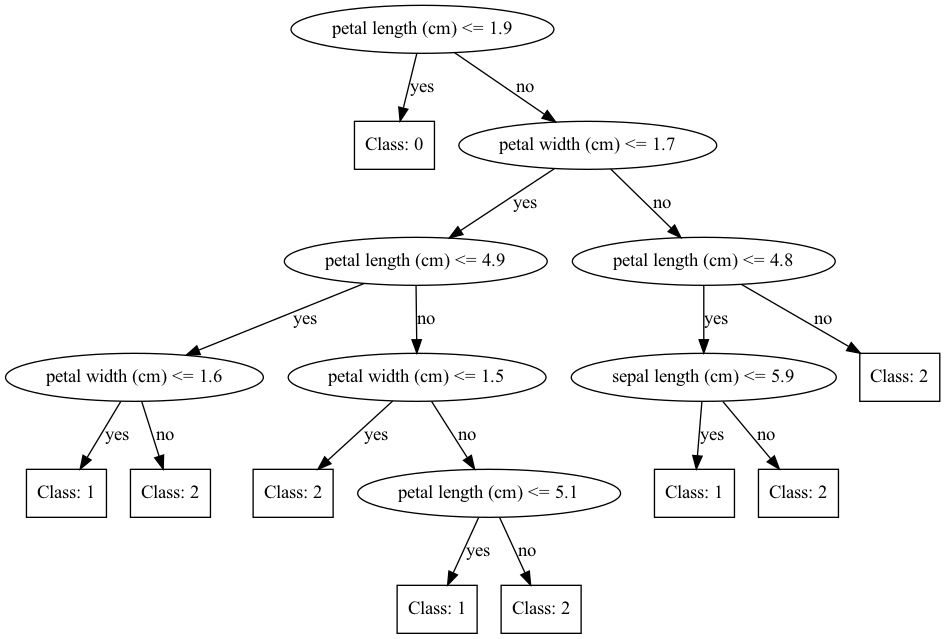

In [3]:
# Visualize the tree
graph = visualize_tree(clf, iris.feature_names)
graph.write_pdf("iris_decision_tree_corrected.pdf")
Image(graph.create_png())

In [5]:
# Create a zip file for submission
import zipfile

with zipfile.ZipFile('project_submission.zip', 'w') as zipf:
    zipf.write('decision_tree_implementation.ipynb')
    zipf.write('iris_decision_tree_corrected.pdf')

print("Zip file created successfully!")

Zip file created successfully!
